In [831]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

from matplotlib import gridspec

In [832]:
#load dataset
data = pd.read_csv("./creditcard.csv")

In [833]:
# get the shape of the data frame
print(data.shape)

(284807, 31)


In [834]:
# create labels
labels=["Valid","Fraud"]

# get count list
li = data["Class"].value_counts().tolist()
values = [li[0], li[1]]

# plot data
fig = px.pie(values=data['Class'].value_counts(),names=labels ,width=600,
             height=400,color_discrete_sequence=["orange","blue"],
             title="Fraud vs Valid transactions")
fig.show()

In [835]:
# data has a class imbalance since there are
# many more valid than fraudulent transactions
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

print(f"Fraud Cases: {len(data[data['Class'] == 1])}")
print(f"Valid Transactions: {len(data[data['Class'] == 0])}")

Fraud Cases: 492
Valid Transactions: 284315


In [836]:
#the amount details for fraudulent transaction
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [837]:
#the amount details for normal transaction
valid.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

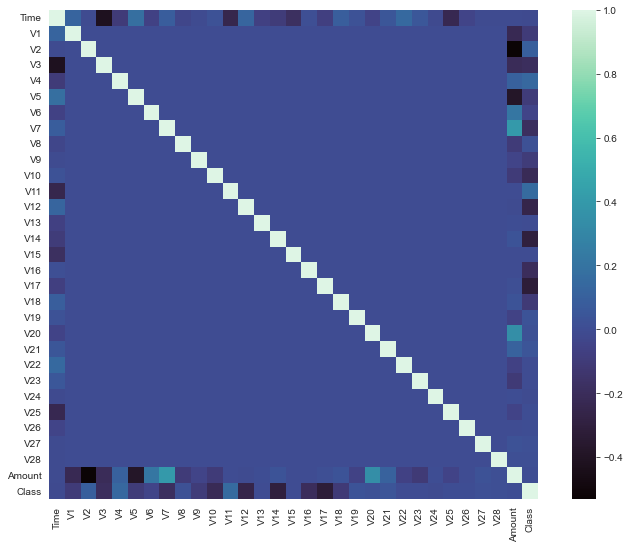

In [838]:
#plotting the correlation matrix
corr = data.corr()
# could use abs value for correlation as we can treat negatively and positively correlated as both being important
#corr = data.corr().abs()
fig = plt.figure(figsize = (12, 9))
sns.color_palette("mako", as_cmap=True)
sns.heatmap(corr, cmap="mako", square = True)
plt.show()

In [839]:
colors = ['#C4C7DF','#4C4C4C', "blue"]
mat = corr.unstack()
mat = mat[mat.between(0.1, 1, inclusive='neither')]

print(mat['Class'])
corr = data.corrwith(data['Class']).sort_values(ascending = False)

corr.columns = ['Correlation']
res = []
for i in range(len(corr)):
    if corr.iloc[i] > 0.1 or corr.iloc[i] < -0.1:
        res.append(corr.iloc[i])



corr = [x for x in corr if x > 0.1 or x < -0.1]
print(corr, res)


V4     0.133447
V11    0.154876
dtype: float64
[0.9999999999999998, 0.15487564474394697, 0.13344748623900424, -0.10134729859508473, -0.11148525388904085, -0.18725659151429688, -0.19296082706741338, -0.19653894030401806, -0.21688294364102748, -0.2605929248772168, -0.3025436958044035, -0.32648106724371373] [0.9999999999999998, 0.15487564474394697, 0.13344748623900424, -0.10134729859508473, -0.11148525388904085, -0.18725659151429688, -0.19296082706741338, -0.19653894030401806, -0.21688294364102748, -0.2605929248772168, -0.3025436958044035, -0.32648106724371373]


In [840]:
#separating the X and the Y values
x = data.drop(['Class'], axis = 1)

# only use the features with an abs value correlation above a certain threshold, we have to decide what matters and doesn't even a weak correlation could be useful
#X = data[['V3','V4','V7','V10','V11','V12','V14','V16','V17']].copy(deep = True)
y = data["Class"]
print(x.shape)
print(y.shape)
# getting just the values for the sake of processing
# (its a numpy array with no columns)
x_data = x.values
y_data = y.values

(284807, 30)
(284807,)


In [841]:
#training and testing data bifurcation


#split the data into training and testing sets
# for later, don't run SMOTE on test data, only training.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

In [842]:
# store overall results here
final_results = {}

In [843]:
# baseline models
# FYI, this cell might take a bit to finish loading,
# import classifier


# create the classifier object, the more estimators
# the longer it will take to run, diminishing returns at a point
# later we will more finely tune the model's parameters along with
rfc = RandomForestClassifier(n_estimators=10, max_depth=13, min_samples_split=9, random_state=42)

# train the data
rfc.fit(x_train, y_train)

# get predictions
y_pred = rfc.predict(x_test)





In [844]:
# base line xgb
# train xgb model
xgb = XGBClassifier(n_estimators=10, max_delta_step=1, eval_metric='aucpr', random_state=42)

# train the data
xgb.fit(x_train, y_train)

# get predictions
y_pred_xgb = xgb.predict(x_test)

In [845]:
# base line results
results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUPRC": average_precision_score(y_test, y_pred),
}

final_results["RFC_BASELINE"] = results.copy()


# solve for accuracy, precision, recall, f1 score and auprc
results_xgb = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1 Score": f1_score(y_test, y_pred_xgb),
    "AUPRC": average_precision_score(y_test, y_pred_xgb),
}

final_results["XGB_BASELINE"] = results_xgb.copy()


________________________________
Random Forest Classifier Results
________________________________
Accuracy: 0.9995435553526912
Precision: 0.95
Recall: 0.7755102040816326
F1 Score: 0.8539325842696629
AUPRC: 0.7371209162714276


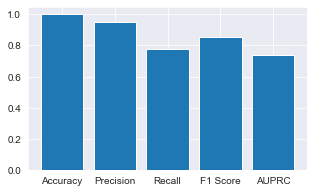

In [846]:
# show results
print("________________________________")
print("Random Forest Classifier Results")
print("________________________________")
for [k, v] in results.items():
    print(f"{k}: {v}")

vals = results.values()
names = results.keys()

fig = plt.figure(figsize = (5, 3))
plt.bar(names, vals)
plt.show()


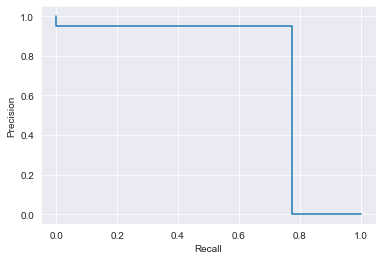

In [847]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

________________________________
XGB Classifier Results
________________________________
Accuracy: 0.9996137776061234
Precision: 0.9634146341463414
Recall: 0.8061224489795918
F1 Score: 0.8777777777777778
AUPRC: 0.7769637199646289


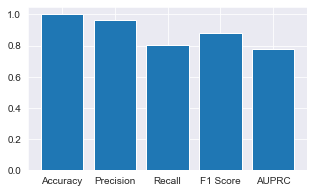

In [848]:
print("________________________________")
print("XGB Classifier Results")
print("________________________________")
for [k, v] in results_xgb.items():
    print(f"{k}: {v}")

vals = results_xgb.values()
names = results_xgb.keys()

fig = plt.figure(figsize = (5, 3))
plt.bar(names, vals)
plt.show()

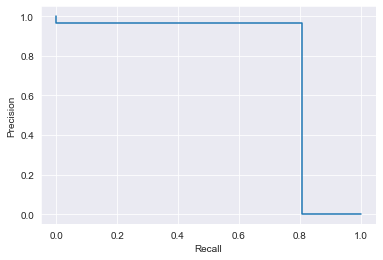

In [849]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_xgb)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [850]:
# smote only random forest classifier
print("--RFC + SMOTE--")
# separate data
x = data.drop('Class', axis=1)
y = data['Class']

# using stratified kfold for imbalanced dataset to validate
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1

# used to track results after all k folds validations
res_acc = []
res_prec = []
res_rec = []
res_f1 = []
res_auprc = []


# loop over every fold
for train_idx, test_idx in sfk.split(x, y):

    x = data.drop('Class', axis=1)
    y = data['Class']

    # use smote to oversample data
    smt = SMOTE(random_state=13)
    x, y = smt.fit_resample(x, y)
    
    print(f"Fold: {fold} | Valid: {np.bincount(y)[0]} | Fraud: {np.bincount(y)[1]}")
    
    # get the training data
    x_train, x_test = x.loc[train_idx], x.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] 
    
    # create the forest classifier model
    rfc = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_split=6, random_state=13)
    
    # train the model on the data
    rfc.fit(x_train, y_train)
    
    # get predictions
    y_pred = rfc.predict(x_test)
    
    print(classification_report(y_test, y_pred))
    
    # solve for accuracy, precision, recall, f1 score and auprc and store for avg
    res_acc += [accuracy_score(y_test, y_pred)]
    res_prec += [precision_score(y_test, y_pred)]
    res_rec += [recall_score(y_test, y_pred)]
    res_f1 += [f1_score(y_test, y_pred)]
    res_auprc += [average_precision_score(y_test, y_pred)]
    
    # print current results
    results = {
        "Accuracy": res_acc[-1],
        "Precision": res_prec[-1],
        "Recall": res_rec[-1],
        "F1 Score": res_f1[-1],
        "AUPRC": res_auprc[-1],
    }
    
    print("________________________________")
    for [k, v] in results.items():
        print(f"{k}: {v}")
    print("________________________________")
    #precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    #disp.plot()
    #plt.show()
    
    
    fold += 1

# show avg results after k folds validation
print("\n--Final Results--")
print(f"Avg Accuracy: {np.mean(res_acc)}")
print(f"Avg Precision: {np.mean(res_prec)}")
print(f"Avg Recall: {np.mean(res_rec)}")
print(f"Avg F1 Score: {np.mean(res_f1)}")
print(f"Avg AUPRC: {np.mean(res_auprc)}")   

final_results["RFC_SMOTE"] = {
    "Accuracy": np.mean(res_acc),
    "Precision": np.mean(res_prec),
    "Recall": np.mean(res_rec),
    "F1 Score": np.mean(res_f1),
    "AUPRC": np.mean(res_auprc),
}


--RFC + SMOTE--
Fold: 1 | Valid: 284315 | Fraud: 284315
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.89      0.77      0.83        99

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962

________________________________
Accuracy: 0.9994382219725431
Precision: 0.8941176470588236
Recall: 0.7676767676767676
F1 Score: 0.826086956521739
AUPRC: 0.6867971231741092
________________________________
Fold: 2 | Valid: 284315 | Fraud: 284315
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.75      0.84        99

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

________________________________
Accuracy: 0

In [851]:
print("--RFC + NearMiss--")

# separate data
x = data.drop('Class', axis=1)
y = data['Class']

# under sample with near miss  
nm = NearMiss(sampling_strategy=0.5)
x, y = nm.fit_resample(x, y)

# using stratified kfold for imbalanced dataset to validate
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1

# used to track results after all k folds validations
res_acc = []
res_prec = []
res_rec = []
res_f1 = []
res_auprc = []


# loop over every fold
for train_idx, test_idx in sfk.split(x, y):
    x = data.drop('Class', axis=1)
    y = data['Class']

    # under sample with near miss  
    nm = NearMiss(sampling_strategy=0.5)
    x, y = nm.fit_resample(x, y)
    
    print(f"Fold: {fold} | Valid: {np.bincount(y)[0]} | Fraud: {np.bincount(y)[1]}")
    
    # get the training data
    x_train, x_test = x.loc[train_idx], x.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] 

    # create the forest classifier model
    rfc = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_split=9, random_state=13)
    
    # train the model on the data
    rfc.fit(x_train, y_train)
    
    # get predictions
    y_pred = rfc.predict(x_test)
    print(classification_report(y_test, y_pred))

    # solve for accuracy, precision, recall, f1 score and auprc and store for avg
    res_acc += [accuracy_score(y_test, y_pred)]
    res_prec += [precision_score(y_test, y_pred)]
    res_rec += [recall_score(y_test, y_pred)]
    res_f1 += [f1_score(y_test, y_pred)]
    res_auprc += [average_precision_score(y_test, y_pred)]
    
    # print current results
    results = {
        "Accuracy": res_acc[-1],
        "Precision": res_prec[-1],
        "Recall": res_rec[-1],
        "F1 Score": res_f1[-1],
        "AUPRC": res_auprc[-1],
    }
    
    print("________________________________")
    for [k, v] in results.items():
        print(f"{k}: {v}")
    print("________________________________")
    fold += 1

# show avg results after k folds validation
print("\n--Final Results--")
print(f"Avg Accuracy: {np.mean(res_acc)}")
print(f"Avg Precision: {np.mean(res_prec)}")
print(f"Avg Recall: {np.mean(res_rec)}")
print(f"Avg F1 Score: {np.mean(res_f1)}")
print(f"Avg AUPRC: {np.mean(res_auprc)}")


final_results["RFC_NearMiss"] = {
    "Accuracy": np.mean(res_acc),
    "Precision": np.mean(res_prec),
    "Recall": np.mean(res_rec),
    "F1 Score": np.mean(res_f1),
    "AUPRC": np.mean(res_auprc),
}


--RFC + NearMiss--
Fold: 1 | Valid: 984 | Fraud: 492
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       197
           1       0.98      0.90      0.94        99

    accuracy                           0.96       296
   macro avg       0.96      0.94      0.95       296
weighted avg       0.96      0.96      0.96       296

________________________________
Accuracy: 0.9594594594594594
Precision: 0.978021978021978
Recall: 0.898989898989899
F1 Score: 0.9368421052631579
AUPRC: 0.913015663015663
________________________________
Fold: 2 | Valid: 984 | Fraud: 492
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       197
           1       0.99      0.90      0.94        98

    accuracy                           0.96       295
   macro avg       0.97      0.95      0.96       295
weighted avg       0.96      0.96      0.96       295

________________________________
Accuracy: 0.9627118644

In [852]:
print("--RFC + SMOTE + NearMiss--")

# separate data
x = data.drop('Class', axis=1)
y = data['Class']

smt = SMOTE(random_state=13, sampling_strategy=0.4)
x, y = smt.fit_resample(x, y)

# under sample with near miss  
nm = NearMiss(sampling_strategy=0.5)
x, y = nm.fit_resample(x, y)

# using stratified kfold for imbalanced dataset to validate
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1

# used to track results after all k folds validations
res_acc = []
res_prec = []
res_rec = []
res_f1 = []
res_auprc = []


# loop over every fold
for train_idx, test_idx in sfk.split(x, y):
    x = data.drop('Class', axis=1)
    y = data['Class']

    smt = SMOTE(random_state=13, sampling_strategy=0.4)
    x, y = smt.fit_resample(x, y)
    
    # under sample with near miss  
    nm = NearMiss(sampling_strategy=0.5)
    x, y = nm.fit_resample(x, y)
    
    print(f"Fold: {fold} | Valid: {np.bincount(y)[0]} | Fraud: {np.bincount(y)[1]}")
    
    # get the training data
    x_train, x_test = x.loc[train_idx], x.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] 

    # create the forest classifier model
    rfc = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_split=9, random_state=13)
    
    # train the model on the data
    rfc.fit(x_train, y_train)
    
    # get predictions
    y_pred = rfc.predict(x_test)
    print(classification_report(y_test, y_pred))

    # solve for accuracy, precision, recall, f1 score and auprc and store for avg
    res_acc += [accuracy_score(y_test, y_pred)]
    res_prec += [precision_score(y_test, y_pred)]
    res_rec += [recall_score(y_test, y_pred)]
    res_f1 += [f1_score(y_test, y_pred)]
    res_auprc += [average_precision_score(y_test, y_pred)]
    
    # print current results
    results = {
        "Accuracy": res_acc[-1],
        "Precision": res_prec[-1],
        "Recall": res_rec[-1],
        "F1 Score": res_f1[-1],
        "AUPRC": res_auprc[-1],
    }
    
    print("________________________________")
    for [k, v] in results.items():
        print(f"{k}: {v}")
    print("________________________________")
    fold += 1

    
# show avg results after k folds validation
print("\n--Final Results--")
print(f"Avg Accuracy: {np.mean(res_acc)}")
print(f"Avg Precision: {np.mean(res_prec)}")
print(f"Avg Recall: {np.mean(res_rec)}")
print(f"Avg F1 Score: {np.mean(res_f1)}")
print(f"Avg AUPRC: {np.mean(res_auprc)}")

final_results["RFC_SMOTE_NearMiss"] = {
    "Accuracy": np.mean(res_acc),
    "Precision": np.mean(res_prec),
    "Recall": np.mean(res_rec),
    "F1 Score": np.mean(res_f1),
    "AUPRC": np.mean(res_auprc),
}

--RFC + SMOTE + NearMiss--
Fold: 1 | Valid: 227452 | Fraud: 113726
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45491
           1       1.00      0.97      0.98     22745

    accuracy                           0.99     68236
   macro avg       0.99      0.99      0.99     68236
weighted avg       0.99      0.99      0.99     68236

________________________________
Accuracy: 0.9899759657658714
Precision: 0.9981483990425868
Recall: 0.9717300505605627
F1 Score: 0.9847620744965248
AUPRC: 0.979353972649511
________________________________
Fold: 2 | Valid: 227452 | Fraud: 113726
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45491
           1       1.00      0.97      0.98     22745

    accuracy                           0.99     68236
   macro avg       0.99      0.98      0.99     68236
weighted avg       0.99      0.99      0.99     68236

________________________________


In [853]:
print("--XGB + NearMiss--")

# near miss only
# separate data
x = data.drop('Class', axis=1)
y = data['Class']


# under sample with near miss  
nm = NearMiss(sampling_strategy=0.5)
x, y = nm.fit_resample(x, y)

# using stratified kfold for imbalanced dataset to validate
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1

# used to track results after all k folds validations
res_acc = []
res_prec = []
res_rec = []
res_f1 = []
res_auprc = []

# loop over every fold
for train_idx, test_idx in sfk.split(x, y):

    print(f"Fold: {fold} | Valid: {np.bincount(y)[0]} | Fraud: {np.bincount(y)[1]}")
    
    # get the training data
    x_train, x_test = x.loc[train_idx], x.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] 
    
    # create the forest classifier model
    xgb = XGBClassifier(n_estimators=10, max_delta_step=1, eval_metric='aucpr', random_state=42)

    # train the data
    xgb.fit(x_train, y_train)

    # get predictions
    y_pred_xgb = xgb.predict(x_test)
    print(classification_report(y_test, y_pred_xgb))

    # solve for accuracy, precision, recall, f1 score and auprc and store for avg
    res_acc += [accuracy_score(y_test, y_pred_xgb)]
    res_prec += [precision_score(y_test, y_pred_xgb)]
    res_rec += [recall_score(y_test, y_pred_xgb)]
    res_f1 += [f1_score(y_test, y_pred_xgb)]
    res_auprc += [average_precision_score(y_test, y_pred_xgb)]
    
    # print current results
    results = {
        "Accuracy": res_acc[-1],
        "Precision": res_prec[-1],
        "Recall": res_rec[-1],
        "F1 Score": res_f1[-1],
        "AUPRC": res_auprc[-1],
    }
    
    print("________________________________")
    for [k, v] in results.items():
        print(f"{k}: {v}")
    print("________________________________")
    
    #precision, recall, _ = precision_recall_curve(y_test, y_pred_xgb)
    #disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    #disp.plot()
    #plt.show()
    
    fold += 1
    
# show avg results after k folds validation
print("\n--Final Results--")
print(f"Avg Accuracy: {np.mean(res_acc)}")
print(f"Avg Precision: {np.mean(res_prec)}")
print(f"Avg Recall: {np.mean(res_rec)}")
print(f"Avg F1 Score: {np.mean(res_f1)}")
print(f"Avg AUPRC: {np.mean(res_auprc)}")

final_results["XGB_NearMiss"] = {
    "Accuracy": np.mean(res_acc),
    "Precision": np.mean(res_prec),
    "Recall": np.mean(res_rec),
    "F1 Score": np.mean(res_f1),
    "AUPRC": np.mean(res_auprc),
}

--XGB + NearMiss--
Fold: 1 | Valid: 984 | Fraud: 492
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       197
           1       0.99      0.90      0.94        99

    accuracy                           0.96       296
   macro avg       0.97      0.95      0.96       296
weighted avg       0.96      0.96      0.96       296

________________________________
Accuracy: 0.9628378378378378
Precision: 0.9888888888888889
Recall: 0.898989898989899
F1 Score: 0.9417989417989419
AUPRC: 0.9227849061182395
________________________________
Fold: 2 | Valid: 984 | Fraud: 492
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       197
           1       0.99      0.91      0.95        98

    accuracy                           0.97       295
   macro avg       0.97      0.95      0.96       295
weighted avg       0.97      0.97      0.97       295

________________________________
Accuracy: 0.96610169

In [854]:
print("--XGB + SMOTE + NearMiss--")

# separate data
x = data.drop('Class', axis=1)
y = data['Class']


smt = SMOTE(random_state=13, sampling_strategy=0.4)
x, y = smt.fit_resample(x, y)

# under sample with near miss  
nm = NearMiss(sampling_strategy=0.5)
x, y = nm.fit_resample(x, y)


# using stratified kfold for imbalanced dataset to validate
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1

# used to track results after all k folds validations
res_acc = []
res_prec = []
res_rec = []
res_f1 = []
res_auprc = []

# loop over every fold
for train_idx, test_idx in sfk.split(x, y):

    print(f"Fold: {fold} | Valid: {np.bincount(y)[0]} | Fraud: {np.bincount(y)[1]}")
    
    # get the training data
    x_train, x_test = x.loc[train_idx], x.loc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] 
    
    # create the forest classifier model
    xgb = XGBClassifier(n_estimators=10, max_delta_step=1, eval_metric='aucpr', random_state=42)

    # train the data
    xgb.fit(x_train, y_train)

    # get predictions
    y_pred_xgb = xgb.predict(x_test)
    print(classification_report(y_test, y_pred_xgb))

    # solve for accuracy, precision, recall, f1 score and auprc and store for avg
    res_acc += [accuracy_score(y_test, y_pred_xgb)]
    res_prec += [precision_score(y_test, y_pred_xgb)]
    res_rec += [recall_score(y_test, y_pred_xgb)]
    res_f1 += [f1_score(y_test, y_pred_xgb)]
    res_auprc += [average_precision_score(y_test, y_pred_xgb)]
    
    # print current results
    results = {
        "Accuracy": res_acc[-1],
        "Precision": res_prec[-1],
        "Recall": res_rec[-1],
        "F1 Score": res_f1[-1],
        "AUPRC": res_auprc[-1],
    }
    
    print("________________________________")
    for [k, v] in results.items():
        print(f"{k}: {v}")
    print("________________________________")
    
    
    #precision, recall, _ = precision_recall_curve(y_test, y_pred_xgb)
    #disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    #disp.plot()
    #plt.show()
    
    fold += 1

# show avg results after k folds validation
print("\n--Final Results--")
print(f"Avg Accuracy: {np.mean(res_acc)}")
print(f"Avg Precision: {np.mean(res_prec)}")
print(f"Avg Recall: {np.mean(res_rec)}")
print(f"Avg F1 Score: {np.mean(res_f1)}")
print(f"Avg AUPRC: {np.mean(res_auprc)}")   

final_results["XGB_SMOTE_NearMiss"] = {
    "Accuracy": np.mean(res_acc),
    "Precision": np.mean(res_prec),
    "Recall": np.mean(res_rec),
    "F1 Score": np.mean(res_f1),
    "AUPRC": np.mean(res_auprc),
}

--XGB + SMOTE + NearMiss--
Fold: 1 | Valid: 227452 | Fraud: 113726
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45491
           1       0.99      0.97      0.98     22745

    accuracy                           0.99     68236
   macro avg       0.99      0.98      0.99     68236
weighted avg       0.99      0.99      0.99     68236

________________________________
Accuracy: 0.988349258455947
Precision: 0.9938354931605472
Recall: 0.9710705649593318
F1 Score: 0.9823211545731504
AUPRC: 0.9747273975131139
________________________________
Fold: 2 | Valid: 227452 | Fraud: 113726
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45491
           1       0.99      0.97      0.98     22745

    accuracy                           0.99     68236
   macro avg       0.99      0.98      0.99     68236
weighted avg       0.99      0.99      0.99     68236

________________________________


In [855]:
print("________________________________")
for [k, v] in final_results.items():
    print(k)
    for [ke, va] in v.items():
        print(f"\t{ke}: {va}")
    print("\n")

________________________________
RFC_BASELINE
	Accuracy: 0.9995435553526912
	Precision: 0.95
	Recall: 0.7755102040816326
	F1 Score: 0.8539325842696629
	AUPRC: 0.7371209162714276


XGB_BASELINE
	Accuracy: 0.9996137776061234
	Precision: 0.9634146341463414
	Recall: 0.8061224489795918
	F1 Score: 0.8777777777777778
	AUPRC: 0.7769637199646289


RFC_SMOTE
	Accuracy: 0.999511950469036
	Precision: 0.9409641236198694
	Recall: 0.766295609152752
	F1 Score: 0.8444745495739102
	AUPRC: 0.7214041418115088


RFC_NearMiss
	Accuracy: 0.967485112230875
	Precision: 0.9869961406429615
	Recall: 0.9146361574933003
	F1 Score: 0.9492638076545395
	AUPRC: 0.9311241567842726


RFC_SMOTE_NearMiss
	Accuracy: 0.9894541820347869
	Precision: 0.9985154206326495
	Recall: 0.9698045996293821
	F1 Score: 0.9839497048854907
	AUPRC: 0.9784298802943636


XGB_NearMiss
	Accuracy: 0.9674828218048557
	Precision: 0.9826727524749227
	Recall: 0.9186971758400329
	F1 Score: 0.94951264592773
	AUPRC: 0.9298800008551427


XGB_SMOTE_NearMis